## Imports

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


## Preprocessing


In [6]:
def preprocess_image(image):

    if image is None:
        return None
        
    # Initialize results dictionary
    preprocessed = {}
    
    # Resize
    resized = cv2.resize(image, (256, 256))
    preprocessed["resized"] = resized
    
    # Normalize
    normalized = (resized / 255.0).clip(0, 1)
    preprocessed["normalized"] = (normalized * 255).astype(np.uint8)
    
    # Denoise
    preprocessed["denoised"] = cv2.GaussianBlur(resized, (5, 5), 0)
    
    # Grayscale + Equalization
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    preprocessed["gray"] = gray
    preprocessed["equalized"] = cv2.equalizeHist(gray)
    
    # HSV
    preprocessed["hsv"] = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    
    # Flipped
    preprocessed["flipped"] = cv2.flip(resized, 1)
    
    # Rotated
    preprocessed["rotated"] = cv2.rotate(resized, cv2.ROTATE_90_CLOCKWISE)
    
    # Blurred
    preprocessed["blurred"] = cv2.GaussianBlur(resized, (7, 7), 0)
    
    # Sharpened
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    preprocessed["sharpened"] = cv2.filter2D(resized, -1, sharpen_kernel)
    
    # Thresholded
    _, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    preprocessed["thresholded"] = thresholded
    
    # Eroded
    kernel = np.ones((5, 5), np.uint8)
    preprocessed["eroded"] = cv2.erode(thresholded, kernel, iterations=1)
    
    # Dilated
    preprocessed["dilated"] = cv2.dilate(thresholded, kernel, iterations=1)
    
    return preprocessed

## segmentation

In [7]:
def segment_image(image, num_clusters=3):

    if image is None:
        return None
        
    # Convert to RGB
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape for K-means
    Z = img_rgb.reshape((-1, 3)).astype(np.float32)
    
    # K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert back to image
    centers = np.uint8(centers)
    segmented = centers[labels.flatten()].reshape(img_rgb.shape)
    
    # Convert back to BGR
    return cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR)

## Feature extraction

In [8]:
sift_features = ['sift_keypoints', 'sift_avg_response', 'sift_max_response', 'sift_avg_size']
sift_descriptors = [f'sift_desc_{i}' for i in range(32)]
gaussian_features = [f'gaussian_mean_sigma{sigma}' for sigma in [1, 3, 5]] + \
                    [f'gaussian_std_sigma{sigma}' for sigma in [1, 3, 5]]
harris_features = ['harris_mean', 'harris_std', 'harris_max', 'harris_corner_count']
bgr_features = [f'{ch}_{stat}' for ch in ['B', 'G', 'R'] for stat in ['mean', 'std', 'median', 'range']]
hsv_features = [f'{ch}_{stat}' for ch in ['H', 'S', 'V'] for stat in ['mean', 'std', 'median', 'range']]
glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
glcm_features = [f'glcm_{prop}_dist{dist}_angle{angle}' 
                 for prop in glcm_props 
                 for dist in [1, 3] 
                 for angle in [0, 45, 90, 135]]
hu_moment_features = [f'hu_moment_{i}' for i in range(7)]

feature_names = (sift_features + sift_descriptors + gaussian_features + harris_features +
                bgr_features + hsv_features + glcm_features + hu_moment_features)


def extract_features_from_image(image):
    features = []
    
    # Convert to color spaces
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # 1. SIFT Features
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None and len(keypoints) > 0:
        n_keypoints = len(keypoints)
        avg_response = np.mean([kp.response for kp in keypoints])
        max_response = np.max([kp.response for kp in keypoints])
        avg_size = np.mean([kp.size for kp in keypoints])
        avg_descriptors = np.mean(descriptors, axis=0) if descriptors.size > 0 else np.zeros(128)
        features.extend([n_keypoints, avg_response, max_response, avg_size])
        features.extend(avg_descriptors[::4])  # Take every 4th value 32 features
    else:
        features.extend([0, 0, 0, 0])
        features.extend(np.zeros(32))
    
    # 2. Gaussian Features
    for sigma in [1, 3, 5]:
        gaussian = cv2.GaussianBlur(gray, (0, 0), sigma)
        features.append(np.mean(gaussian))
        features.append(np.std(gaussian))
    
    # 3. Harris Corner
    harris = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
    features.append(np.mean(harris))
    features.append(np.std(harris))
    features.append(np.max(harris))
    features.append(np.sum(harris > 0.01 * harris.max()))
    
    # 4. Color Features BGR and HSV
    for i in range(3):
        channel = image[:, :, i]
        features.append(np.mean(channel))
        features.append(np.std(channel))
        features.append(np.median(channel))
        features.append(np.max(channel) - np.min(channel))
    
    for i in range(3):
        channel = hsv[:, :, i]
        features.append(np.mean(channel))
        features.append(np.std(channel))
        features.append(np.median(channel))
        features.append(np.max(channel) - np.min(channel))
    
    # 5. Texture Features GLCM
    glcm = graycomatrix(gray, distances=[1, 3], 
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    
    for prop in glcm_props:
        prop_values = graycoprops(glcm, prop)
        features.extend(prop_values.flatten())
    
    # 6. Shape Features Hu Moments
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments['m00'] != 0:
            hu_moments = cv2.HuMoments(moments)
            hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
            features.extend(hu_moments.flatten())
        else:
            features.extend(np.zeros(7))
    else:
        features.extend(np.zeros(7))
    
    return np.array(features)

def extract_features(input_path):
    if os.path.isfile(input_path):
        # Single image case
        image = cv2.imread(input_path)
        if image is None:
            raise ValueError(f"Could not read image {input_path}")
        features = extract_features_from_image(image)
        return features  # ready for model.predict
    elif os.path.isdir(input_path):
        # Folder case
        all_features = []
        all_labels = []
        
        fruit_folders = sorted([folder for folder in os.listdir(input_path) 
                               if os.path.isdir(os.path.join(input_path, folder))])
        
        print(f"Found {len(fruit_folders)} fruit folders.")
        
        for fruit_folder in tqdm(fruit_folders, desc="Processing fruit folders"):
            fruit_name = '_'.join(fruit_folder.split('_')[1:]) if '_' in fruit_folder else fruit_folder
            folder_path = os.path.join(input_path, fruit_folder)
            images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            for image_file in images:
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"cant not read {image_path}")
                    continue
                features = extract_features_from_image(image)
                all_features.append(features)
                all_labels.append(fruit_name)
        
        df = pd.DataFrame(all_features, columns=feature_names)
        df['fruit_type'] = all_labels
        return df
    else:
        raise ValueError(f"Invalid input path: {input_path}")

In [9]:
def process_fruit_dataset(input_dir):
    all_features = []
    all_labels = []
    
    # Check if input_dir has subdirectories or just images
    has_subdirs = any(os.path.isdir(os.path.join(input_dir, item)) for item in os.listdir(input_dir))
    
    if has_subdirs:
        # Case where input_dir contains category folders
        fruit_folders = sorted([folder for folder in os.listdir(input_dir) 
                               if os.path.isdir(os.path.join(input_dir, folder))])
        
        print(f"Found {len(fruit_folders)} fruit folders.")
        
        for fruit_folder in tqdm(fruit_folders, desc="Processing fruit folders"):
            fruit_name = '_'.join(fruit_folder.split('_')[1:]) if '_' in fruit_folder else fruit_folder
            folder_path = os.path.join(input_dir, fruit_folder)
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Cannot read {image_path}")
                    continue
                
                # Preprocess and segment in memory (no saving)
                preprocessed = preprocess_image(image)
                segmented = segment_image(preprocessed["resized"])
                
                # Extract features from the segmented image
                features = extract_features_from_image(segmented)
                all_features.append(features)
                all_labels.append(fruit_name)
    else:
        # Case where input_dir contains images directly
        image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        for image_file in tqdm(image_files, desc="Processing images"):
            # Try to extract fruit name from filename
            base_name = os.path.splitext(image_file)[0]
            fruit_name = '_'.join(base_name.split('_')[1:]) if '_' in base_name else base_name
            
            image_path = os.path.join(input_dir, image_file)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Cannot read {image_path}")
                continue
            
            # Preprocess and segment in memory (no saving)
            preprocessed = preprocess_image(image)
            segmented = segment_image(preprocessed["resized"])
            
            # Extract features from the segmented image
            features = extract_features_from_image(segmented)
            all_features.append(features)
            all_labels.append(fruit_name)
    
    # Create DataFrame with features and labels
    df = pd.DataFrame(all_features, columns=feature_names)
    df['fruit_type'] = all_labels
    return df

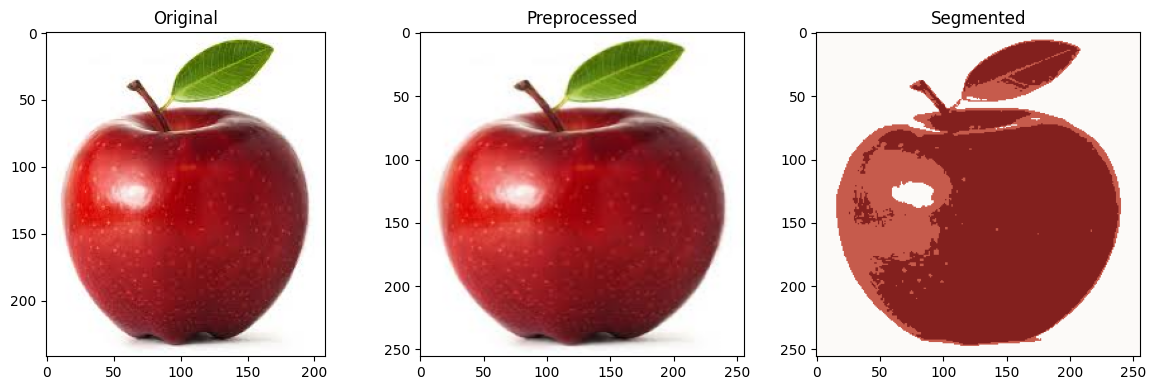

In [10]:
image = cv2.imread("fruit_image.jpg")
if image is not None:
    preprocessed = preprocess_image(image)
    segmented = segment_image(preprocessed["resized"])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(preprocessed["resized"], cv2.COLOR_BGR2RGB))
    plt.title("Preprocessed")
    
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    plt.title("Segmented")
    
    plt.tight_layout()
    plt.show()

## Process the dataset and create csv file contaning the features

In [ ]:
df = process_fruit_dataset("Images")

df.to_csv("fruit_features.csv", index=False)

Processing images:   0%|          | 2/400 [00:00<01:58,  3.35it/s]C:\Users\mahmoud\AppData\Local\Temp\ipykernel_23744\3181449619.py:88: RuntimeWarning: divide by zero encountered in log10
  hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
C:\Users\mahmoud\AppData\Local\Temp\ipykernel_23744\3181449619.py:88: RuntimeWarning: invalid value encountered in multiply
  hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
Processing images: 100%|██████████| 400/400 [02:23<00:00,  2.79it/s]


## split the df and preprocess the features

In [ ]:
X = df.drop('fruit_type', axis=1)
y = df['fruit_type']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (320, 117)
X_test shape: (80, 117)
y_train shape: (320,)
y_test shape: (80,)
